In [1]:
import itertools
import json
import os
import re
import sqlite3
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from matplotlib.lines import Line2D

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.stretch'] = 'condensed'

In [2]:
## CHANGE IF NECESSARY
DB_PATH = os.path.expanduser('~/webform-data.db')

db_uri = Path(DB_PATH).as_uri() + '?mode=ro'
con = sqlite3.connect(db_uri, uri=True)

In [3]:
cur = con.execute('''
    SELECT ranking, domain, content_categories
    FROM domain_info di
    INNER JOIN tranco_list tl USING (domain)
''')

rows = set()
id2category = {-1: 'Unknown'}
id2parent = {-1: -1}

for row in cur:
    ranking, domain, content_categories_json = row

    content_categories = json.loads(content_categories_json)

    for item in content_categories:
        id2category[item['id']] = item['name']

        if 'super_category_id' in item:
            id2parent[item['id']] = item['super_category_id']
            rows.add((ranking, domain, item['id'], item['super_category_id']))

    if len(content_categories) == 0:
        rows.add((ranking, domain, -1, -1))

df_domain = pd.DataFrame(list(rows), columns=['ranking', 'domain', 'category_id', 'super_category_id'])
df_domain['category'] = df_domain['category_id'].map(id2category)
df_domain['super_category'] = df_domain['super_category_id'].map(id2category)
df_domain.set_index('domain', inplace=True)
df_domain.sort_index(inplace=True)

# Take parent category for some website categories
df_domain['website_category'] = df_domain['category']
df_domain.loc[df_domain.super_category == "Government & Politics", "website_category"] = 'Government & Politics'
df_domain.loc[df_domain.super_category == "Health", "website_category"] = 'Health'
df_domain.loc[df_domain.super_category == "Shopping & Auctions", "website_category"] = 'Shopping & Auctions'
df_domain.loc[df_domain.super_category == "Society & Lifestyle", "website_category"] = 'Society & Lifestyle'
df_domain.loc[df_domain.super_category == "Internet Communication", "website_category"] = 'Internet Communication'

df_domain_category = df_domain.groupby('domain').agg({'website_category': frozenset})
df_domain_category

,website_category
domain,
1001fonts.com,(Society & Lifestyle)
100datingsite.com,"(Business, Shopping & Auctions, Internet Commu..."
101domain.com,(Information Technology)
101xp.com,"(Society & Lifestyle, Gaming)"
1024tera.com,(File Sharing)
...,...
zyfra.com,(Unknown)
zynga.com,(Gaming)
zyro.com,(Information Technology)


## Web Form Dataset -- Statistics

In [4]:
cur = con.execute('''
    SELECT domain, job_hash, form_filename, form_type, field_list
    FROM form_classification a
         INNER JOIN field_classification b
         USING (domain, job_hash, form_filename)
''')

ID_TYPES = {"Address", "EmailAddress", "GovernmentId", "BankAccountNumber", "PersonName", "PhoneNumber", "UsernameOrOtherId", "TaxId"}
unique_records = defaultdict(set)
web_form_count = 0

for row in cur:
    domain, job_hash, form_filename, form_type, field_list_json = row

    field_list = json.loads(field_list_json)

    if ID_TYPES.isdisjoint(field_list):
        continue

    web_form_count += 1
    unique_records[domain, form_type].update(field_list)

df = pd.DataFrame([[*t, frozenset(l)] for t, l in unique_records.items()], columns=['domain', 'form_type', 'data_type'])
df = df.join(df_domain_category, on='domain', how='outer').reset_index(drop=True)
df.loc[df.data_type.isna(), 'data_type'] = frozenset()

In [5]:
# Number of domains
n_total_domains = df.domain.nunique()
n_total_domains

11500

In [6]:
# Number of web forms, after cleaning up (Section 4.3 -- Dataset Cleaning)
web_form_count

292655

In [7]:
# Number of domains, by form type (Table 4 left column)

SELECTED_FORM_TYPES = [
    'Role Application Form',
    'Financial Application Form',
    'Payment Form',
    'Reservation Form',
    'Contact Form',
    'Content Submission Form',
    'Subscription Form',
    'Account Registration Form',
    'Account Login Form',
    'Account Recovery Form',
    'Unknown',
]

assert set(df.form_type.dropna().unique()) == set(SELECTED_FORM_TYPES)

for form_type in SELECTED_FORM_TYPES:
    count = df.loc[df.form_type == form_type].domain.nunique()
    print(
        "{:22s}".format(form_type.rsplit(' ', 1)[0]),
        "{:5,}".format(count),
        "{:5.1f}\\%".format(100 * count / n_total_domains),
        sep=' & ', end=' \\\\\n'
    )

Role Application       &   959 &   8.3\% \\
Financial Application  &   175 &   1.5\% \\
Payment                & 1,096 &   9.5\% \\
Reservation            &   413 &   3.6\% \\
Contact                & 6,304 &  54.8\% \\
Content Submission     &   831 &   7.2\% \\
Subscription           & 4,613 &  40.1\% \\
Account Registration   & 5,138 &  44.7\% \\
Account Login          & 7,159 &  62.3\% \\
Account Recovery       & 5,054 &  43.9\% \\
Unknown                & 1,748 &  15.2\% \\


In [8]:
# Number of domains, by data type (Table 4 right column)

SELECTED_DATA_TYPES = [
    'EmailAddress',
    'PhoneNumber',
    'PersonName',

    'Address',
    'LocationCityOrCoarser',
    'PostalCode',

    'AgeOrAgeGroup',
    'DateOfBirth',

    'BankAccountNumber',
    'GovernmentId',
    'TaxId',

    'UsernameOrOtherId',

    'Ethnicity',
    'Gender',
    'CitizenshipOrImmigrationStatus',
    'MilitaryStatus',
]

for data_type in SELECTED_DATA_TYPES:
    count = df.loc[df.data_type.apply(lambda s: data_type in s)].domain.nunique()
    print(
        "{:30s}".format(data_type),
        "{:5,}".format(count),
        "{:5.1f}\\%".format(100 * count / n_total_domains),
        sep=' & ', end=' \\\\\n'
    )

EmailAddress                   & 9,805 &  85.3\% \\
PhoneNumber                    & 4,704 &  40.9\% \\
PersonName                     & 7,804 &  67.9\% \\
Address                        & 2,244 &  19.5\% \\
LocationCityOrCoarser          & 3,792 &  33.0\% \\
PostalCode                     & 2,493 &  21.7\% \\
AgeOrAgeGroup                  &   249 &   2.2\% \\
DateOfBirth                    & 1,324 &  11.5\% \\
BankAccountNumber              &   530 &   4.6\% \\
GovernmentId                   &   155 &   1.3\% \\
TaxId                          &   170 &   1.5\% \\
UsernameOrOtherId              & 4,244 &  36.9\% \\
Ethnicity                      &   137 &   1.2\% \\
Gender                         &   466 &   4.1\% \\
CitizenshipOrImmigrationStatus &   280 &   2.4\% \\
MilitaryStatus                 &    69 &   0.6\% \\


In [9]:
# Table 3 footnote

SELECTED_WEBSITE_CATEGORIES = """
Gaming
Video Streaming
Internet Communication
News & Media
Society & Lifestyle
Shopping & Auctions
Travel
Economy & Finance
Health
Government & Politics
Educational Institutions
""".strip().split('\n')

n_domains_in_selected_categories = df.domain[df.website_category.apply(lambda s: not s.isdisjoint(SELECTED_WEBSITE_CATEGORIES))].nunique()
n_domains_in_selected_categories, n_domains_in_selected_categories / n_total_domains

(6121, 0.5322608695652173)

## Common Patterns -- Contact Info (Section 5.1 / Figure 4)

EmailAddress: 0.853
PersonName: 0.679
PhoneNumber: 0.409
Address: 0.195
EmailAddress: 0.853
PersonName: 0.679
PhoneNumber: 0.409
Address: 0.195


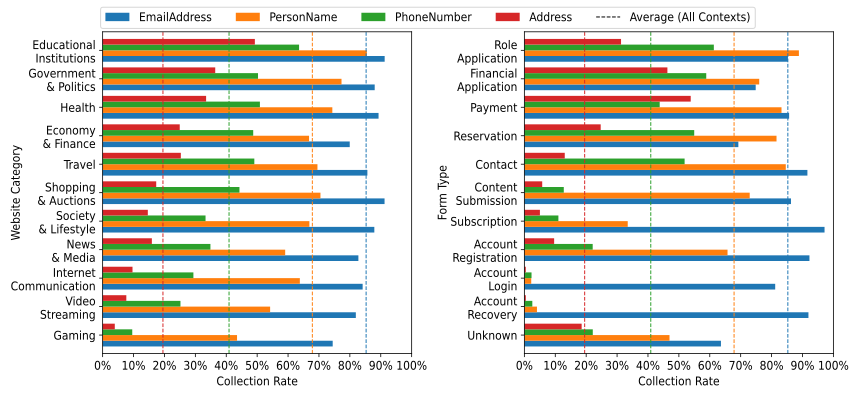

In [10]:
# Collection rates of contact info types (Figure 4)

def form_type_rename(form_type):
    if form_type == "All":
        return "(Any Forms)"
    
    form_type = form_type.replace(' Form', '')

    candidates = [m.start() for m in re.finditer(r'\W+', form_type)]

    if len(candidates) > 0:
        pos = min(candidates, key=lambda x: abs(x * 2 - len(form_type)))
        return form_type[:pos] + '\n' + form_type[pos:]
    else:
        return form_type

def website_category_rename(website_category):
    if website_category == "All":
        return "(All Categories)"

    website_category = website_category.replace(', and', ' &')
    candidates = [m.start() for m in re.finditer(r'\W+', website_category)]

    if len(candidates) > 0:
        pos = min(candidates, key=lambda x: abs(x * 2 - len(website_category)))
        return website_category[:pos] + '\n' + website_category[pos:]
    else:
        return website_category

MAJOR_DATA_TYPES = ['EmailAddress', 'PersonName', 'PhoneNumber', 'Address']
COLORS = sns.color_palette("tab10", len(MAJOR_DATA_TYPES))

df_stat_data_types = pd.DataFrame(
    0.0,
    index=SELECTED_WEBSITE_CATEGORIES,
    columns=MAJOR_DATA_TYPES,
)

fig, axs = plt.subplots(1, 2, figsize=(12, 5.5))

for color, data_type in zip(COLORS, MAJOR_DATA_TYPES):
    df["collected"] = df.data_type.apply(lambda s: data_type in s)

    n_domain = df.domain.nunique()
    n_collect = df.query("collected").domain.nunique()
    col_rate = n_collect / n_domain
    print(f'{data_type}: {col_rate:.3f}')

    axs[0].axvline(col_rate, color=color, linestyle='--', linewidth=1)

    for category in SELECTED_WEBSITE_CATEGORIES:
        subset = df[df.website_category.apply(lambda s: category in s)]
        n_domain = subset.domain.nunique()
        n_collect = subset.query("collected").domain.nunique()

        df_stat_data_types.loc[category, data_type] = n_collect / n_domain

df_stat_data_types.plot.barh(ax=axs[0], color=COLORS, legend=False, width=0.8)

df_stat_forms = pd.DataFrame(
    0.0,
    index=SELECTED_FORM_TYPES[::-1],
    columns=MAJOR_DATA_TYPES,
)

for color, data_type in zip(COLORS, MAJOR_DATA_TYPES):
    df["collected"] = df.data_type.apply(lambda s: data_type in s)

    n_domain = df.domain.nunique()
    n_collect = df.query("collected").domain.nunique()
    col_rate = n_collect / n_domain
    print(f'{data_type}: {col_rate:.3f}')

    axs[1].axvline(col_rate, color=color, linestyle='--', linewidth=1)

    for form_type in SELECTED_FORM_TYPES:
        subset = df[df.form_type == form_type]
        n_domain = subset.domain.nunique()
        n_collect = subset.query("collected").domain.nunique()

        df_stat_forms.loc[form_type, data_type] = n_collect / n_domain

df_stat_forms.plot.barh(ax=axs[1], color=COLORS, legend=False, width=0.8)

handles, labels = axs[0].get_legend_handles_labels()
handles.append(Line2D([0], [0], color='black', lw=1, linestyle='--', label='Average (All Contexts)'))
labels.append('Average (All Contexts)')
fig.legend(
    handles,
    labels,
    ncol=5,
    loc='upper center', bbox_to_anchor=(0.5, 1),
    prop={'size': 12}
)

axs[0].set_yticklabels(
    [website_category_rename(i.get_text()) for i in axs[0].get_yticklabels()],
    rotation=0, size=12)
axs[0].set_xlim(0.0, 1.0)
axs[0].set_xticks(np.linspace(0, 1, 11))
axs[0].set_xticklabels([f'{i:.0%}' for i in axs[0].get_xticks()], size=12)
axs[0].set_xlabel('Collection Rate', size=12)
axs[0].set_ylabel('Website Category', size=12, labelpad=-15)

axs[1].set_yticklabels(
    [form_type_rename(i.get_text()) for i in axs[1].get_yticklabels()],
    rotation=0, size=12)
axs[1].set_xlim(0.0, 1.0)
axs[1].set_xticks(np.linspace(0, 1, 11))
axs[1].set_xticklabels([f'{i:.0%}' for i in axs[1].get_xticks()], size=12)
axs[1].set_xlabel('Collection Rate', size=12)
axs[1].set_ylabel('Form Type', size=12, labelpad=0)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('bar_contact.pdf')
plt.show()

## Common Patterns -- Other PI (Section 5.1 / Figure 5)

DateOfBirth


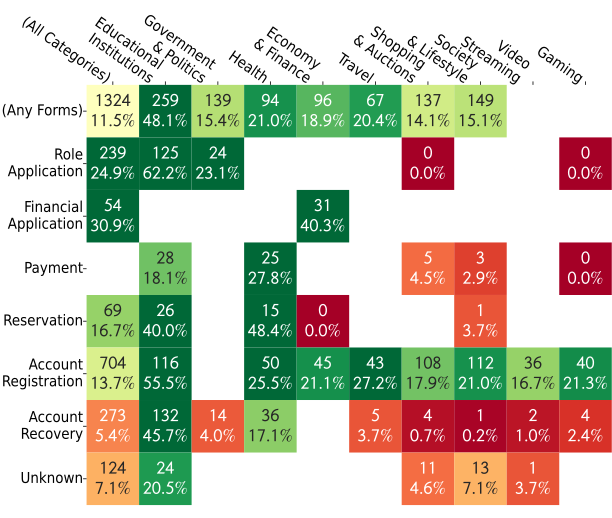

AgeOrAgeGroup


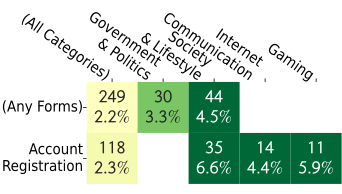

BankAccountNumber


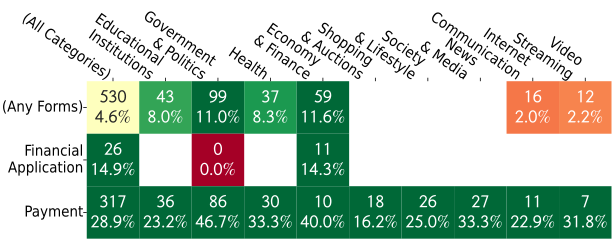

TaxId


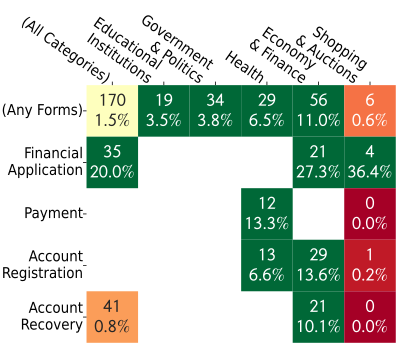

GovernmentId


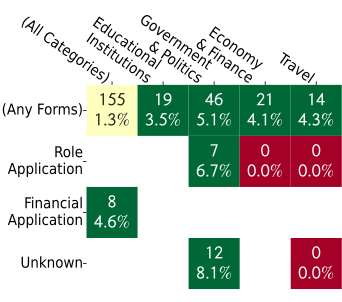

Gender


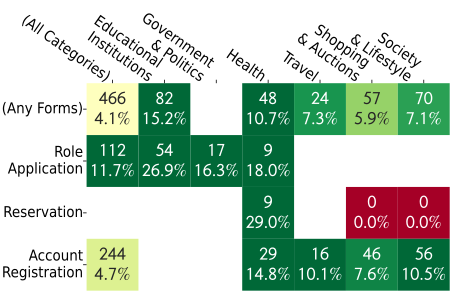

CitizenshipOrImmigrationStatus


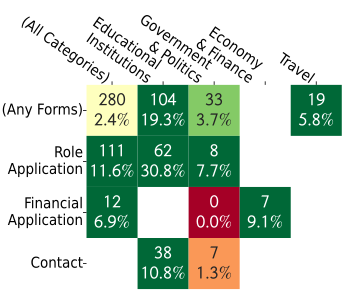

Ethnicity


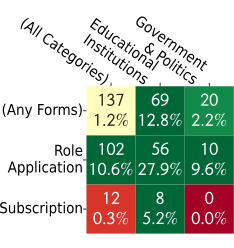

MilitaryStatus


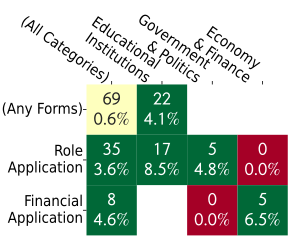

In [11]:
# Collection rates heatmaps (Figure 5)
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', bbox_inches=None)

def bernoulli_t_test(n1p, n1, n2p, n2):
    if n1 <= 1 or n2 <= 1:
        return np.nan, np.nan, np.nan
    
    p1 = n1p / n1
    p2 = n2p / n2

    sp1 = p1 * (1 - p1) / (n1 - 1)
    sp2 = p2 * (1 - p2) / (n2 - 1)

    t = (p1 - p2) / np.sqrt(sp1 + sp2)
    df = (sp1 + sp2) ** 2 / (sp1 ** 2 / (n1 - 1) + sp2 ** 2 / (n2 - 1))

    pval = stats.t.sf(abs(t), df) * 2

    return t, df, pval


for data_type in [
    # 'EmailAddress',
    # 'PhoneNumber',
    # 'PersonName',

    # 'Address',
    # 'LocationCityOrCoarser',
    # 'PostalCode',

    'DateOfBirth',
    'AgeOrAgeGroup',

    'BankAccountNumber',
    'TaxId',
    'GovernmentId',

    'Gender',
    'CitizenshipOrImmigrationStatus',
    'Ethnicity',
    'MilitaryStatus',
]:
    df['collected'] = df.data_type.apply(lambda s: data_type in s)

    df_domain_count = pd.DataFrame(
        0,
        columns=['All'] + SELECTED_WEBSITE_CATEGORIES[::-1],
        index=['All'] + SELECTED_FORM_TYPES,
        dtype=int
    )
    df_collect_count = df_domain_count.copy()
    df_p = df_collect_count.astype(float)

    n_domain_all = df.domain.nunique()
    n_collect_all = df.query('collected').domain.nunique()

    df_domain_count.at['All', 'All'] = n_domain_all
    df_collect_count.at['All', 'All'] = n_collect_all
    df_p.at['All', 'All'] = 0.0

    for y_label in SELECTED_WEBSITE_CATEGORIES:
        ymask = df.website_category.apply(lambda s: y_label in s)
        subset = df[ymask]
        rest_set = df[~ymask]

        n_domain = subset.domain.nunique()
        n_collect = subset.query('collected').domain.nunique()
        n_domain_rest = rest_set.domain.nunique()
        n_collect_rest = rest_set.query('collected').domain.nunique()

        df_domain_count.at['All', y_label] = n_domain
        df_collect_count.at['All', y_label] = n_collect
        *_, df_p.at['All', y_label] = bernoulli_t_test(n_collect, n_domain, n_collect_rest, n_domain_rest)

        for x_label in SELECTED_FORM_TYPES:
            xmask = ymask & (df.form_type == x_label)
            subset = df[xmask]
            rest_set = df[~xmask]

            n_domain = subset.domain.nunique()
            n_collect = subset.query('collected').domain.nunique()
            n_domain_rest = rest_set.domain.nunique()
            n_collect_rest = rest_set.query('collected').domain.nunique()

            df_domain_count.at[x_label, y_label] = n_domain
            df_collect_count.at[x_label, y_label] = n_collect
            *_, df_p.at[x_label, y_label] = bernoulli_t_test(n_collect, n_domain, n_collect_rest, n_domain_rest)


    for x_label in SELECTED_FORM_TYPES:
        xmask = df.form_type == x_label
        subset = df[xmask]
        rest_set = df[~xmask]

        n_domain = subset.domain.nunique()
        n_collect = subset.query('collected').domain.nunique()
        n_domain_rest = rest_set.domain.nunique()
        n_collect_rest = rest_set.query('collected').domain.nunique()

        df_domain_count.at[x_label, 'All'] = n_domain
        df_collect_count.at[x_label, 'All'] = n_collect
        *_, df_p.at[x_label, 'All'] = bernoulli_t_test(n_collect, n_domain, n_collect_rest, n_domain_rest)

    df_collection_rate = df_collect_count / df_domain_count
    df_collection_rate[df_domain_count < 10] = np.nan

    avg_collection_rate = df_collection_rate.at['All', 'All']

    P_THRESHOLD = 0.05
    df_collection_rate[df_p > P_THRESHOLD] = np.nan
    x_mask = df_collection_rate.max(1) > avg_collection_rate
    y_mask = df_collection_rate.max(0) > avg_collection_rate
    x_mask.loc['All'] = y_mask.loc['All'] = True

    df_selected = df_collection_rate.loc[x_mask, y_mask]
    df_mask = ~(df_p.loc[x_mask, y_mask].abs() < P_THRESHOLD)
    df_mask.loc['All', 'All'] = False

    df_label = df_selected.astype(str)

    for i, j in itertools.product(df_label.index, df_label.columns):
        n_collect = df_collect_count.at[i, j]
        collection_rate = df_collection_rate.at[i, j]
        df_label.at[i, j] = f"${n_collect:d}$\n${collection_rate * 100.0:.1f}\\%$"

    cellsize = 0.75 #inch
    marg_top = 1.0
    marg_bottom = 0.0
    marg_left = 1.2
    marg_right = 0.0
    cells_in_row = len(df_selected.columns)
    cells_in_column = len(df_selected.index)
    figwidth = cellsize * cells_in_row + marg_top + marg_bottom
    figheight = cellsize * cells_in_column + marg_left + marg_right

    fig, ax = plt.subplots(figsize=(figwidth, figheight))
    fig.subplots_adjust(bottom =marg_bottom/figheight ,top=1.-marg_top/figheight,
                        left=marg_left/figwidth, right=1.-marg_right/figwidth)

    g = sns.heatmap(
        df_selected,
        annot=df_label,
        fmt='',
        annot_kws={"fontsize": 18},
        cbar=False,
        cmap=sns.color_palette("RdYlGn", as_cmap=True),
        vmin=0.0, vmax=2.0 * avg_collection_rate,
        ax=ax,
        square=True,
        mask=df_mask,
    )

    ax.tick_params(axis='y', which='major', pad=0, labelsize=15)
    ax.tick_params(axis='x', which='major', pad=-5, labelsize=15, labelbottom=False, bottom=False, top=True, labeltop=True)

    ax.set_xticklabels(
        [website_category_rename(i.get_text()) for i in ax.get_xticklabels()],
        rotation=-35, ha='right', size=15)
    ax.set_yticklabels([form_type_rename(i.get_text()) for i in ax.get_yticklabels()],
        rotation=0, va='center', size=15)

    print(data_type)
    # print(figwidth, figheight)
    plt.savefig(f'heatmap_{data_type}.pdf')
    plt.show()

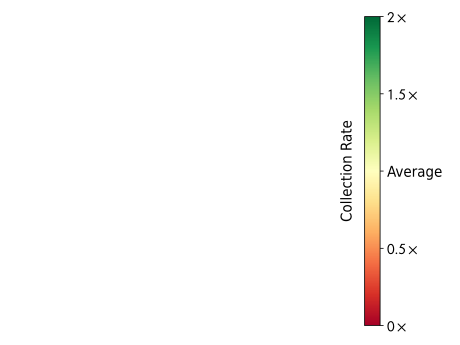

In [12]:
# Just a color bar (Figure 5)

img = plt.imshow(np.array([[0, 2.0]]), cmap="RdYlGn")
plt.gca().set_visible(False)

cbar = plt.colorbar(orientation="vertical")
cbar.ax.yaxis.set_label_position('left') 
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_ylabel('Collection Rate', size=15, labelpad=10)
yticks = np.arange(0.0, 2.0 + 1e-6, 0.5)
cbar.ax.set_yticks(yticks)
cbar.ax.set_yticklabels([rf'${i:g}\times$' if i != 1.0 else 'Average' for i in yticks])

plt.tight_layout()
plt.savefig(f'heatmap_colorbar.pdf')
plt.show()

## Uncommon Cases (Section 5.2)

In [13]:
def query_collection_rate(data_type, website_category=None, form_type=None):
    if website_category:
        filter1 = df.website_category.apply(lambda s: website_category in s)
    else:
        filter1 = np.repeat(True, len(df.index))

    if form_type:
        filter2 = df.form_type == form_type
    else:
        filter2 = np.repeat(True, len(df.index))
    
    subset = df[filter1 & filter2]

    n_domain = subset.domain.nunique()
    n_collect = subset[subset.data_type.apply(lambda s: data_type in s)].domain.nunique()

    return n_collect / n_domain

collection_rate_table = {}

ALL_WEBSITE_CATEGORIES = frozenset.union(*df.website_category)

for data_type in SELECTED_DATA_TYPES:
    for website_category in [None] + sorted(ALL_WEBSITE_CATEGORIES):
        for form_type in [None] + SELECTED_FORM_TYPES:
            try:
                collection_rate_table[data_type, website_category, form_type] = query_collection_rate(data_type, website_category, form_type)
            except AttributeError:
                continue

In [14]:
to_be_checked = []

for _, row in df.iterrows():
    form_type = row['form_type']
    data_type_list = row['data_type'] & set(SELECTED_DATA_TYPES)
    website_category_list = row['website_category'] #& set(SELECTED_WEBSITE_CATEGORIES)
    domain = row['domain']

    if len(website_category_list) == 0:
        continue

    for data_type in data_type_list:
        #max_collection_rate = collection_rate_table[data_type, None, form_type]
        max_collection_rate = 0.0

        for website_category in website_category_list:
            #max_collection_rate = max(max_collection_rate, collection_rate_table[data_type, website_category, None])
            max_collection_rate = max(max_collection_rate, collection_rate_table[data_type, website_category, form_type])

        if max_collection_rate < 0.025:
            to_be_checked.append((domain, data_type, form_type, website_category, max_collection_rate))

df_tbc = pd.DataFrame(to_be_checked, columns=['domain', 'data_type', 'form_type', 'website_category', 'max_collection_rate'])
df_tbc

,domain,data_type,form_type,website_category,max_collection_rate
0,ecwid.com,PersonName,Account Login Form,Business,0.014677
1,cyberlink.com,AgeOrAgeGroup,Subscription Form,Technology,0.019713
2,castanet.net,AgeOrAgeGroup,Subscription Form,Video Streaming,0.010638
3,truthfinder.com,LocationCityOrCoarser,Account Recovery Form,Search Engines,0.021277
4,truthfinder.com,PersonName,Account Recovery Form,Search Engines,0.021277
...,...,...,...,...,...
1212,paizo.com,UsernameOrOtherId,Subscription Form,Shopping & Auctions,0.016129
1213,porkbun.com,LocationCityOrCoarser,Account Login Form,Information Technology,0.006547
1214,porkbun.com,Address,Account Login Form,Information Technology,0.009820
1215,porkbun.com,PersonName,Account Login Form,Information Technology,0.016367


In [15]:
# n websites with uncommon PI collection (Section 5.2)
df_tbc.domain.nunique()

855

In [16]:
# Specific examples of uncommon cases (Section 5.2)

df_tbc[df_tbc.domain == 'macys.com']

,domain,data_type,form_type,website_category,max_collection_rate
891,macys.com,DateOfBirth,Subscription Form,Shopping & Auctions,0.023297


In [17]:
df_tbc[df_tbc.domain == 'metopera.org']

,domain,data_type,form_type,website_category,max_collection_rate
1117,metopera.org,Ethnicity,Account Registration Form,Music,0.017857


In [18]:
df_tbc[df_tbc.domain.isin(['colgate.com', 'sleepnumber.com'])]

,domain,data_type,form_type,website_category,max_collection_rate
662,colgate.com,Gender,Subscription Form,Health,0.015544
780,sleepnumber.com,Gender,Content Submission Form,Business,0.009091
781,sleepnumber.com,AgeOrAgeGroup,Content Submission Form,Business,0.018182


In [19]:
query_collection_rate('DateOfBirth', None, 'Subscription Form')

0.023195317580750056

In [20]:
query_collection_rate('Ethnicity', None, 'Account Registration Form')

0.0023355391202802647

In [21]:
query_collection_rate('Gender', None, 'Content Submission Form')

0.009626955475330927

In [22]:
query_collection_rate('AgeOrAgeGroup', None, 'Content Submission Form')

0.018050541516245487